# SED fitting using eazy-py on the SPHEREx yarn cluster

### install eazy-py from https://github.com/gbrammer/eazy-py
- For templates and filters, https://github.com/gbrammer/eazy-photoz/

### what you need: 
- `premade-tempfilt.pickle` : sed-fit-grid which has all of filters and templates information

### what `ez` is: 
> `inputcatalog in csv` + `premade-tempfilt` + `param` <br> 

### Broadcasting `ez` is not possible. File-by-file parallization will be applied.

- original input: fits file on hdfs
- final output: parquet table 

### Batch Size Optimization

- 12288 cat files that we have to process
- optimal batch size ? and optimal number of executors ? 
    - 150 files with 100 executors can achieve a running time for `min` + `max` combination 

# Basic Packages

In [1]:
#!pip list |grep pyarrow

In [2]:
# import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import os
import numpy as np
from astropy.table import Table
from matplotlib.ticker import MultipleLocator
import pandas as pd

from astropy.utils.exceptions import AstropyWarning
import warnings

pd.set_option('display.max_rows', 300)
    
np.seterr(all='ignore')
warnings.simplefilter('ignore', category=AstropyWarning)

# https://github.com/gbrammer/eazy-py
import eazy

In [3]:
import numpy as np
import pandas as pd
import glob
import sys
import h5py
#from netCDF4 import Dataset
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

import pyarrow as pa
import pyarrow.parquet as pq

from functools import reduce
import operator
import gc

In [4]:
# plot settings
#plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

In [5]:
!pip list |grep eazy

/usr/bin/pip:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point
eazy                      0.6.8               


# PySpark Session

In [6]:
%%time
# PySpark packages
from pyspark import SparkContext   
from pyspark.sql import SparkSession

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark import Row
from pyspark.sql.window import Window as W


spark = SparkSession.builder \
    .master("yarn") \
    .appName("spark-shell") \
    .config("spark.driver.maxResultSize", "32g") \
    .config("spark.driver.memory", "32g") \
    .config("spark.executor.memory", "7g") \
    .config("spark.executor.cores", "1") \
    .config("spark.executor.instances", "20") \
    .getOrCreate()


sc = spark.sparkContext
sc.setCheckpointDir("hdfs://spark00:54310/tmp/checkpoints")

spark.conf.set("spark.sql.debug.maxToStringFields", 500)
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

CPU times: user 14.9 ms, sys: 4.13 ms, total: 19.1 ms
Wall time: 32.3 s


# Input Files

> `parquet` files on `hadoop file system`. <br> 
Unfortunately, the **parquet** file is not a **dataframe** but an **astropy table**. 

### Hadoop File System

In [7]:
hdfsheader = 'hdfs://spark00:54310'
datapath = '/user/yyang/external-catalogs/raw/refcat/original/'
workpath = '/user/shong/work/sedfit/spherex/data/temp/'

## Spark DataFrame for the Catalog File List 

In [8]:
hdfsheader+workpath+'refcat-list.parquet.snappy'

'hdfs://spark00:54310/user/shong/work/sedfit/spherex/data/temp/refcat-list.parquet.snappy'

In [9]:
df = spark.read.parquet(hdfsheader+workpath+'refcat-list.parquet.snappy')

In [10]:
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- size: double (nullable = true)
 |-- irank: integer (nullable = true)



In [11]:
df.show(3,truncate=False)

+---------------------------------------------------------------+-------+-----+
|name                                                           |size   |irank|
+---------------------------------------------------------------+-------+-----+
|Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE32_000030.parquet|18.7712|1    |
|Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE32_000028.parquet|19.4544|2    |
|Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE32_000024.parquet|20.1404|3    |
+---------------------------------------------------------------+-------+-----+
only showing top 3 rows



In [12]:
df.orderBy(df['irank'].desc()).show(3,truncate=True)

+--------------------+-------+-----+
|                name|   size|irank|
+--------------------+-------+-----+
|Gaia_DR3.LS.PS1DR...|572.447|12288|
|Gaia_DR3.LS.PS1DR...|570.862|12287|
|Gaia_DR3.LS.PS1DR...|566.999|12286|
+--------------------+-------+-----+
only showing top 3 rows



#### `toPandas()` then visualize the file size statistics

In [13]:
pdf = df.toPandas()
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12288 entries, 0 to 12287
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   name    12288 non-null  object 
 1   size    12288 non-null  float64
 2   irank   12288 non-null  int32  
dtypes: float64(1), int32(1), object(1)
memory usage: 240.1+ KB


In [14]:
pdf["size"].describe()

count    12288.000000
mean        72.990726
std         52.957251
min         18.771200
25%         50.088500
50%         60.941500
75%         74.298100
max        572.447000
Name: size, dtype: float64

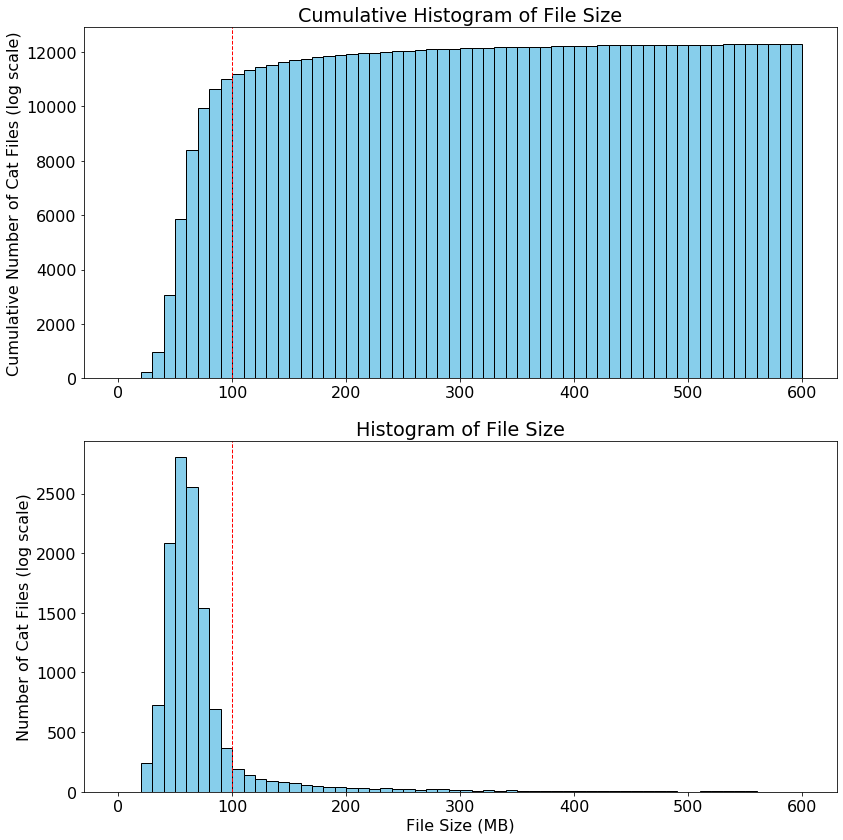

In [15]:
# Set the minimum and maximum values for the x-axis
x_min = 0
x_max = 600  # Adjust this value according to your data

# Create a figure with two subplots vertically arranged
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Plot the second histogram (cumulative frequency histogram)
axs[0].hist(pdf['size'], bins=60, range=(x_min, x_max), cumulative=True, color='skyblue', edgecolor='black')
axs[0].set_title('Cumulative Histogram of File Size')
axs[0].set_ylabel('Cumulative Number of Cat Files (log scale)')

# Plot the vertical line at size=100 for the first histogram
axs[0].axvline(x=100, color='red', linestyle='dashed', linewidth=1)

# Plot the first histogram (frequency histogram)
axs[1].hist(pdf['size'], bins=60, range=(x_min, x_max), color='skyblue', edgecolor='black')
#axs[1].set_yscale('log')  # Set y-axis to log scale
axs[1].set_title('Histogram of File Size')
axs[1].set_ylabel('Number of Cat Files (log scale)')
# Plot the vertical line at size=100 for the first histogram
axs[1].axvline(x=100, color='red', linestyle='dashed', linewidth=1)
axs[1].set_xlabel('File Size (MB)')

# Adjust layout
plt.tight_layout()

# Save the plot as a PNG file
#plt.savefig('catfile_stats.png')

# Show the plot
plt.show()

> Most of 12+k files are less than 100 MB. <br> 
Hence, our running time should be determined by the performance on these 11k small catalog files.

# Generate EazyPy Input Catalogs from RefCat

### Generate Full Path Names for RefCat

#### HDFS path

In [16]:
incatlist = [hdfsheader+datapath+x for x in pdf['name'].values.tolist()]

In [17]:
incatlist[0]

'hdfs://spark00:54310/user/yyang/external-catalogs/raw/refcat/original/Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE32_000030.parquet'

In [18]:
len(incatlist)

12288

> Hadoop access is not possible for some cases

#### Raid5 Mount Path

In [19]:
raidpath = '/mnt/raid5/yyang/SPHEREx_RefCat/'

In [20]:
incatlist = [raidpath+x for x in pdf['name'].values.tolist()]

In [21]:
incatlist[0]

'/mnt/raid5/yyang/SPHEREx_RefCat/Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE32_000030.parquet'

In [22]:
len(incatlist)

12288

#### Input EazyPy Catalog List

In [23]:
ineazypath = '/user/shong/data/spherex/eazypy-input/'

In [24]:
ineazylist = [hdfsheader+ineazypath+x.rsplit('.',1)[0]+"_eazyinput.cat" for x in pdf['name'].values.tolist()]

In [25]:
ineazylist[0]

'hdfs://spark00:54310/user/shong/data/spherex/eazypy-input/Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE32_000030_eazyinput.cat'

#### Input EazyPy Catalog List in Raid5 

In [26]:
ineazyraidpath = '/mnt/raid5/shong/eazypy-inputcat/'

In [27]:
ineazylist = [ineazyraidpath+x.rsplit('.',1)[0]+"_eazyinput.cat" for x in pdf['name'].values.tolist()]

In [28]:
ineazylist[0]

'/mnt/raid5/shong/eazypy-inputcat/Gaia_DR3.LS.PS1DR1.CatWISE.AllWISE.2MASS_NSIDE32_000030_eazyinput.cat'

> The saved cat files on a local disk will be copied to HDFS for the PySpark run later.

### Generate EazyPy Input Catalogs from RefCat

#### Header (or Schema)

In [35]:
########## Make EAZY inputfile


# spec z's are unknown, set to an arbitrary negative number as unknown
z_spec = -1.0

bands_ref = ['Gaia_G', 'Gaia_BP', 'Gaia_RP', 
             'WISE_W1','WISE_W2','WISE_W3','WISE_W4',
             '2MASS_J','2MASS_H','2MASS_Ks',
             'PS1_g', 'PS1_r','PS1_i','PS1_z','PS1_y']

#bands_ref = ['WISE_W1','WISE_W2','WISE_W3','WISE_W4',
#             '2MASS_J','2MASS_H','2MASS_Ks',
#             'PS1_g', 'PS1_r','PS1_i','PS1_z','PS1_y']

bands_err = [b + '_error' for b in bands_ref]

bands_eazy = ['gaia_G', 'gaia_BP', 'gaia_RP',
              'w1', 'w2', 'w3', 'w4',
              '2massJ', '2massH', '2massKs',
              'ps1_g', 'ps1_r', 'ps1_i', 'ps1_z', 'ps1_y']

header_list = [' f_'+ b + ' e_' + b for b in bands_eazy]
header_string =  '#id' + ''.join(header_list) + ' z_spec'

print(header_string)

#id f_gaia_G e_gaia_G f_gaia_BP e_gaia_BP f_gaia_RP e_gaia_RP f_w1 e_w1 f_w2 e_w2 f_w3 e_w3 f_w4 e_w4 f_2massJ e_2massJ f_2massH e_2massH f_2massKs e_2massKs f_ps1_g e_ps1_g f_ps1_r e_ps1_r f_ps1_i e_ps1_i f_ps1_z e_ps1_z f_ps1_y e_ps1_y z_spec


In [36]:
from tqdm import tqdm

In [37]:
[len(incatlist), len(ineazylist)]

[12288, 12288]

In [38]:
%%time
for idx in tqdm(range(200), position=0, leave=True):
    inname = incatlist[idx]
    outname = ineazylist[idx]
        
    catphot = Table.read(inname)
    
    with open(outname,'w') as outfile:
        print(header_string, file=outfile)
        for r in catphot:
            ind = r['SPHERExRefID']
            flux_list = [f" {r[b]} {r[e]}" for b, e in zip(bands_ref, bands_err)]
            flux_string = f'{ind}' + ''.join(flux_list) + f' {z_spec}'
            print(flux_string, file=outfile)

100%|██████████| 200/200 [13:26<00:00,  4.03s/it]

CPU times: user 11min 54s, sys: 31 s, total: 12min 25s
Wall time: 13min 26s


> **I have to copy the outputs to HDFS, `hfs -put *.* /user/shong/data/spherex/eazypy-input/`**